In [1]:
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
from tqdm import tqdm

### 0. The Geodesics of the Bloch Sphere

Given one $\frac{1}{2}$-spin, its Hilbert space is $\mathbb{C}^2$ and we chose the basis $B = \{\uparrow, \downarrow\}$. Any wavefunction $\Psi$ can be parametrised by two angles $\theta, \phi$:

$$
\Psi = \cos \frac{\theta}{2} \uparrow + e^{i\phi} \sin \frac{\theta}{2} \downarrow
$$

The resulting wavefunctions form the manifold $M$. We inheret the metric structure of the ambient Hilbert space via the quantum information tensor. This results in a real Riemannian metric:

$$
g_{ij} = 2 \Re\, \langle \partial_i \Psi | \partial_j \Psi \rangle
$$

Here this leads to:

$$
ds^2 =  \frac{1}{2}d\theta^2 + 2 \sin \frac{\theta}{2} d\phi^2
$$

In a variational monte carlo simulation, we can raise and lower indices. The lowering part is more immediate, as the raising involves inverting the above metric. The lowering is written as:

$$
w_i = g_{ij} v^i
$$

We implement it in the folowing snippet:

In [2]:
def apply_g(primals, tangent):

    theta = primals[0]
    orig_shape = tangent.shape
    tangent = tangent.reshape(-1, 2, 1)

    g = jnp.array([[0.5, 0],[0, 2*jnp.sin(theta/2)**2]])
    res = jnp.matmul(g, tangent)
    return res.reshape(orig_shape)

In [3]:
param = jnp.array([0., 1.])
tangents = jnp.ones(shape = (20, 2))

cotangents = apply_g(param, tangents)
cotangents.shape

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


(20, 2)

Using a numerical linear eqation solver (conjugate gradient), we can also raise indices:

In [4]:
def inverse_g(primals, cotangent):
    A = lambda tangents : apply_g(primals, tangents)
    return jax.scipy.sparse.linalg.cg(A, cotangent)[0]

In [5]:
tangents = inverse_g(param, cotangents)
tangents.shape

(20, 2)

We now aim to solve the geodesic equation on this Riemannian manifold. It describes the trajectory of a curve $\gamma : \mathbb{R} \to M$, given by:

$$
\"{\gamma}^i + \Gamma^i_{jk} \dot{\gamma}^j \dot{\gamma}^k = 0
$$

This involves the Christoffel-symbols $\Gamma$ of the Levi-Civita connection, given by:
$$
\Gamma^i_{jk} = \frac{1}{2}g^{il} b_{ljk}
$$

with $b_{ljk} = \partial_j g_{lk} + \partial_k g_{lj} - \partial_l g_{jk}$. We first calculate the expression $b_{ljk}\dot{\gamma}^j\dot{\gamma}^k$ and then raise its index via the conjugate gradient method described above. The first two terms of $b_{ljk}$ give the same result when contracted with $\dot{\gamma}^j\dot{\gamma}^k$. The result of the first, we will calculate with function $a$ and the second one with function $b$.

In [6]:
def a(primals, gamma_dot):
    f = lambda primals : apply_g(primals, gamma_dot)
    res = jax.jvp(f, (primals,), (gamma_dot,))
    return res[1]

def b(primals, gamma_dot):
    f = lambda primals : jnp.sum(gamma_dot * apply_g(primals, gamma_dot))
    res = jax.vjp(f, primals)[1](jnp.array(1.))[0]
    return res

@jax.jit
def geodesic_correction(primals, gamma_dot):
    lower = 2 * a(primals, gamma_dot) - b(primals, gamma_dot)
    raised = inverse_g(primals, lower)
    return 0.5*raised

The implemented geodesic correction function calculates directly all components of $\Gamma^i_{jk}\dot{\gamma}^j\dot{\gamma}^k$. We will also call the collection of these components $\Gamma(\dot{\gamma},\dot{\gamma})$.

### 1. Iterative Integration Scheme
One can discretise the second order geodesic equation. Here we employ

$$
\ddot{\gamma}(t) \approx \frac{1}{\epsilon^2}\left[\gamma(t + \epsilon) - 2 \gamma(t) + \gamma(t - \epsilon)\right]
$$

for the second derivative and
$$
\dot{\gamma}(t) \approx \frac{1}{\epsilon}\left[\gamma(t) - \gamma(t - \epsilon)\right]
$$
with $\epsilon$ being a small time step. The geodesic equation then becomes:

$$
\gamma(t + \epsilon) = 2\gamma(t) - \gamma(t - \epsilon) + \Gamma(\gamma(t)-\gamma(t-\epsilon), \gamma(t)-\gamma(t-\epsilon))
$$

In [93]:
dt = 0.05
T = 15
N_iter = int(T/dt) - 2

t = 0
gamma = jnp.array([jnp.pi/2 - 0.5, 0])
gamma_dot = jnp.array([0,1])


ts = [t, t + dt]
gammas = [gamma - dt * gamma_dot, gamma]
for i in tqdm(range(2, N_iter)):

    delta_gam = gammas[i - 1] - gammas[i - 2]
    cor = geodesic_correction(gammas[i - 1], delta_gam)
    gamma = 2*gammas[i-1] - gammas[i - 2] - cor
    t = ts[i - 1] + dt

    ts.append(t)
    gammas.append(gamma)

gammas = jnp.array(gammas)
ts = jnp.array(ts)

100%|██████████| 296/296 [00:00<00:00, 20601.60it/s]


Text(0.5, 1.0, 'Geodesics of the Bloch sphere')

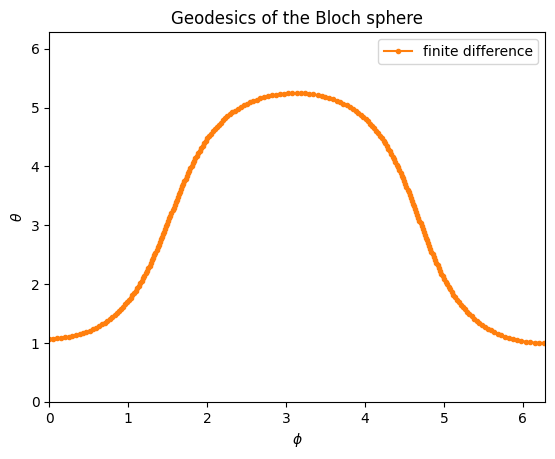

In [97]:
phis = jnp.linspace(jnp.pi/2, jnp.pi*3/2-1e-3)
phis2 = jnp.linspace(0, jnp.pi/2-1e-3)
phis3 = jnp.linspace(jnp.pi*3/2, jnp.pi*2)
coef = 1 / jnp.tan(gammas[0][0])

plt.plot(gammas[:,1], gammas[:, 0], color = "C1", marker = ".", label = "finite difference")
plt.xlim(0, jnp.pi*2)
plt.ylim(0, jnp.pi*2)
plt.ylabel("$\\theta$")
plt.xlabel("$\\phi$")
plt.legend()
plt.title("Geodesics of the Bloch sphere")

### 2. Approximate the Christoffel Symbols (bad)
As in high dimensional settings we would like to avoid taking derivatives of the metric, we employ approximations for the calculation of $b_{ljk}\dot{\gamma}^j\dot{\gamma}^k$:

$$
b_{ljk}\dot{\gamma}^j\dot{\gamma}^k = 2 \partial_j g_{lk}\dot{\gamma}^j\dot{\gamma}^k - \partial_l g_{jk}\dot{\gamma}^j\dot{\gamma}^k
$$

Defining $g_{ij}(t) = g_{ij}(\gamma(t))$, the first term is a total derivative:

$$
2 \partial_j g_{lk}\dot{\gamma}^j\dot{\gamma}^k = 2 (\dot{\gamma}^j \partial_j ) g_{lk}\dot{\gamma}^k =  2 \frac{d}{dt} g(t)_{lk} \dot{\gamma}^k
$$

This can be approximated as a first difference:

$$
2 \frac{d}{dt} g(t)_{lk} \dot{\gamma}^k \approx 2 \frac{1}{\epsilon} \left[g(t)_{lk} \dot{\gamma}^k - g(t - \epsilon)_{lk} \dot{\gamma}^k\right]
$$

This can be evaluated nicely as we store the past positions $\gamma$ and can evaluate $g$ along the way. Indeed, the second term is harder to approximate. Giving it a close look, we identify it as being the gradient of a scalar function. Without incorporating further information of the spatial dependece of $g$, we only now the above total derivative of g, or in other words the projection of the gradient of $g$ along $\dot{\gamma}$. As a result, we can at least incorporate the correct components of the gradient of $g$ along $\dot{\gamma}$. Thus we employ:
$$
\partial_l g_{jk}\dot{\gamma}^j\dot{\gamma}^k \approx \frac{d}{dt}g(t)_{jk}\dot{\gamma}^j\dot{\gamma}^k \frac{\dot{\gamma}^l}{\delta_{mn}\dot{\gamma}^m\dot{\gamma}^n} 
$$
Those two terms will be computed by the below functions $a$ and $b$ respectively.


#### Note:
the approximation of b is very bad, also when applying g once more to lower the index.

In [114]:
def a_approx(gamma, old_gamma, gamma_dot, epsilon):
    x = apply_g(gamma, gamma_dot) -  apply_g(old_gamma, gamma_dot)
    return x/epsilon


def b_approx(gamma, old_gamma, gamma_dot, epsilon):
    x1 = jnp.sum(gamma_dot * apply_g(gamma, gamma_dot))
    x2 = jnp.sum(gamma_dot * apply_g(old_gamma, gamma_dot))

    tot = (x1 - x2) / epsilon

    norm_gamma_dot = gamma_dot / jnp.sum(gamma_dot**2)

    return tot * apply_g(gamma, norm_gamma_dot)

@jax.jit
def geodesic_correction_approx(gamma, old_gamma, gamma_dot, epsilon):
    lower = 2 * a_approx(gamma, old_gamma, gamma_dot, epsilon) - b_approx(gamma, old_gamma, gamma_dot, epsilon)
    # lower = 2 * a_approx(gamma, old_gamma, gamma_dot, epsilon) - b(gamma, gamma_dot)
    raised = inverse_g(gamma, lower)
    return 0.5*raised

In [115]:
eps = 0.05
gamma = jnp.array([jnp.pi/2+1.,0.])
gamma_dot = jnp.array([0.,1.])
old_gamma = gamma - eps * gamma_dot

In [116]:
geodesic_correction(gamma, gamma_dot)

Array([-0.54030234,  0.        ], dtype=float32)

In [117]:
geodesic_correction_approx(gamma, old_gamma, gamma_dot, eps)

Array([0., 0.], dtype=float32)

In [118]:
dt = 0.05
T = 15
N_iter = int(T/dt) - 2

t = 0
gamma = jnp.array([jnp.pi/2-0.5, 0.])
gamma_dot = jnp.array([0.,1.])


ts = [t, t + dt]
gammas = [gamma - dt * gamma_dot, gamma]
for i in tqdm(range(2, N_iter)):

    gamma_dot = (gammas[i - 1] - gammas[i - 2])/dt
    cor = geodesic_correction_approx(gammas[i - 1], gammas[i - 2], gamma_dot, dt)
    gamma = 2*gammas[i-1] - gammas[i - 2] - dt**2 * cor
    t = ts[i - 1] + dt

    ts.append(t)
    gammas.append(gamma)

gammas = jnp.array(gammas)
ts = jnp.array(ts)

100%|██████████| 296/296 [00:00<00:00, 31300.78it/s]


Text(0.5, 1.0, 'Geodesics of the Bloch sphere')

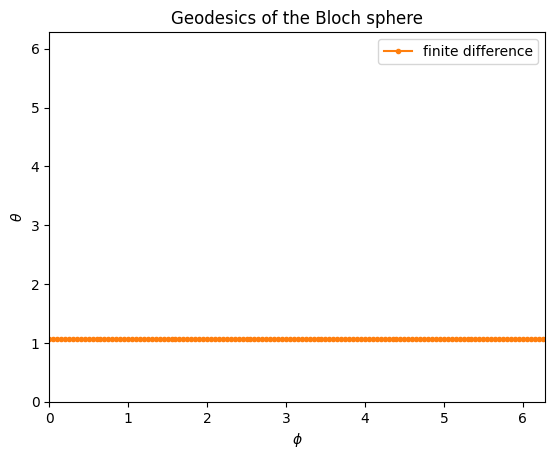

In [119]:
phis = jnp.linspace(jnp.pi/2, jnp.pi*3/2-1e-3)
phis2 = jnp.linspace(0, jnp.pi/2-1e-3)
phis3 = jnp.linspace(jnp.pi*3/2, jnp.pi*2)
coeff = 1 / jnp.tan(gammas[0][0])

plt.plot(gammas[:,1], gammas[:, 0], color = "C1", marker = ".", label = "finite difference")
plt.xlim(0, jnp.pi*2)
plt.ylim(0, jnp.pi*2)
plt.ylabel("$\\theta$")
plt.xlabel("$\\phi$")
plt.legend()
plt.title("Geodesics of the Bloch sphere")

---